

# Defining libraries and processing data from the dataset

In [ ]:

#importing the required libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
!pip install pydicom
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.3 MB/s eta 0:00:00


In [ ]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
import torch

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:393: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


Data preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = torch.as_tensor( ID )
        y = self.labels[index]

        return X, y

patients = []
labels = []
for i in range (1,1000):
  path = "/content/drive/MyDrive/research_data/stage1/image" + " (" + str(i) + ").dcm"
  dicom = pydicom.read_file(path)
  if 'Image Storage' not in dicom.SOPClassUID.name:
   continue
  data_voi = apply_voi_lut(dicom.pixel_array, dicom)
  data = dicom.pixel_array
  data_voi = data_voi - np.min(data_voi)
  data_voi = data_voi / np.max(data_voi)
  data_voi = (data_voi * 255).astype(np.uint8)
  patients.append(data_voi)
  labels.append(0)

for i in range (1,1000):
  path = "/content/drive/MyDrive/research_data/stage2/image" + " (" + str(i) + ").dcm"
  dicom = pydicom.read_file(path)
  if 'Image Storage' not in dicom.SOPClassUID.name:
   continue
  data_voi = apply_voi_lut(dicom.pixel_array, dicom)
  data = dicom.pixel_array
  data_voi = data_voi - np.min(data_voi)
  data_voi = data_voi / np.max(data_voi)
  data_voi = (data_voi * 255).astype(np.uint8)
  patients.append(data_voi)
  labels.append(1)
for i in range (1,2000):
  path = "/content/drive/MyDrive/research_data/stage3a/image" + " (" + str(i) + ").dcm"
  dicom = pydicom.read_file(path)
  if 'Image Storage' not in dicom.SOPClassUID.name:
   continue  # to skip the rest of the loop
  data_voi = apply_voi_lut(dicom.pixel_array, dicom)
  data = dicom.pixel_array
  data_voi = data_voi - np.min(data_voi)
  data_voi = data_voi / np.max(data_voi)
  data_voi = (data_voi * 255).astype(np.uint8)
  patients.append(data_voi)
  labels.append(2)
for i in range (1,2000):
  path = "/content/drive/MyDrive/research_data/stage3b/image" + " (" + str(i) + ").dcm"
  dicom = pydicom.read_file(path)
  if 'Image Storage' not in dicom.SOPClassUID.name:
   continue  # to skip the rest of the loop
  data_voi = apply_voi_lut(dicom.pixel_array, dicom)
  data = dicom.pixel_array
  data_voi = data_voi - np.min(data_voi)
  data_voi = data_voi / np.max(data_voi)
  data_voi = (data_voi * 255).astype(np.uint8)
  patients.append(data_voi)
  labels.append(3)

patient_train, patient_test, label_train, label_test = train_test_split( patients, labels, test_size=0.33, random_state=42)
train_dataset = Dataset(patient_train, label_train)
validation_dataset = Dataset(patient_test, label_test)
plt.figure(figsize = (12,12))
plt.imshow(data_voi, 'gray')
row = len(patient_train[2])
row

Mounted at /content/drive


FileNotFoundError: ignored

In [ ]:
patient_train = np.array(patient_train)
patient_test = np.array(patient_test)
label_train = np.array(label_train)
label_test = np.array(label_test)


data shape for model fitting

In [ ]:
#loading data

#(X_train,y_train) , (X_test,y_test)=mnist.load_data()
#reshaping data
#X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
#X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],X_test.shape[2],1))
#checking the shape after reshaping
print(np.shape(patient_train))
print(np.shape(patient_test))
#normalizing the pixel values
#X_train=X_train/255
#X_test=X_test/255

(3578, 512, 512)
(1763, 512, 512)


# CNN Models

Personal CNN model

In [ ]:
#defining model
model=Sequential()
#adding convolution layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(512,512,1)))
#adding pooling layer
model.add(MaxPool2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(512,512,1)))
#adding pooling layer
model.add(MaxPool2D(2,2))
#adding fully connected layer
model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.2))
#adding output layer
model.add(Dense(4,activation='softmax'))
#compiling the model
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#fitting the model
histroy = model.fit(patient_train,label_train,epochs=10)

Epoch 1/10
154/154 [==============================] - 272s 2s/step - loss: 226.1967 - accuracy: 0.4618
Epoch 2/10
154/154 [==============================] - 273s 2s/step - loss: 0.6772 - accuracy: 0.7212
Epoch 3/10
154/154 [==============================] - 273s 2s/step - loss: 0.3678 - accuracy: 0.8522
Epoch 4/10
154/154 [==============================] - 272s 2s/step - loss: 0.2209 - accuracy: 0.9136
Epoch 5/10
154/154 [==============================] - 271s 2s/step - loss: 0.1924 - accuracy: 0.9229
Epoch 6/10
154/154 [==============================] - 272s 2s/step - loss: 0.1499 - accuracy: 0.9359
Epoch 7/10
 70/154 [============>.................] - ETA: 2:28 - loss: 0.1511 - accuracy: 0.9326

Model evaluation


76/76 [==============================] - 85s 1s/step - loss: 0.0758 - accuracy: 0.9757
dict_keys(['loss', 'accuracy'])


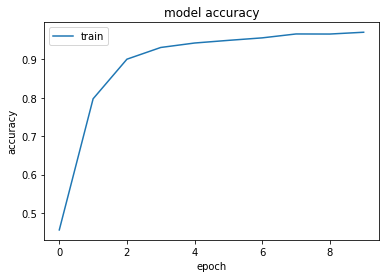

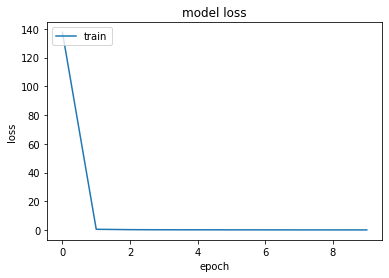

In [ ]:
#evaluting the model
model.evaluate(patient_test,label_test)
print(histroy.history.keys())
# summarize history for accuracy
plt.plot(histroy.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histroy.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Alexnet

In [ ]:
patient_train = patient_train.reshape(4918,512,512,1)
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(512,512,1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(4, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.optimizers.SGD(lr=0.001),metrics=['accuracy'])
#fitting the model
history = model.fit(patient_train,label_train,epochs=10)

Epoch 1/10
154/154 [==============================] - 26s 165ms/step - loss: 1.7045 - accuracy: 0.4640
Epoch 2/10
154/154 [==============================] - 25s 163ms/step - loss: 0.8364 - accuracy: 0.6639
Epoch 3/10
154/154 [==============================] - 25s 160ms/step - loss: 0.5367 - accuracy: 0.8022
Epoch 4/10
154/154 [==============================] - 25s 161ms/step - loss: 0.3500 - accuracy: 0.8843
Epoch 5/10
154/154 [==============================] - 25s 162ms/step - loss: 0.2434 - accuracy: 0.9307
Epoch 6/10
154/154 [==============================] - 25s 162ms/step - loss: 0.1538 - accuracy: 0.9642
Epoch 7/10
154/154 [==============================] - 25s 161ms/step - loss: 0.1100 - accuracy: 0.9780
Epoch 8/10
154/154 [==============================] - 25s 162ms/step - loss: 0.0790 - accuracy: 0.9852
Epoch 9/10
154/154 [==============================] - 25s 162ms/step - loss: 0.0628 - accuracy: 0.9876
Epoch 10/10
154/154 [==============================] - 25s 162ms/step - l

76/76 [==============================] - 4s 48ms/step - loss: 0.0684 - accuracy: 0.9806
dict_keys(['loss', 'accuracy'])


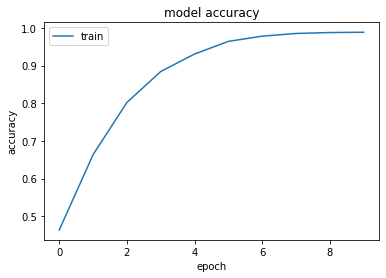

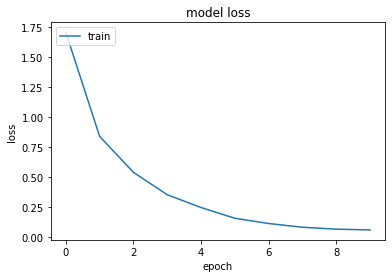

In [ ]:
model.evaluate(patient_test,label_test)
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

VGG 19

In [ ]:
patient_train = patient_train.reshape((3578, 512, 512,1))
model=Sequential()
#adding convolution layer 1
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(512,512,1)))
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(512,512,1)))
model.add(MaxPool2D(2,2))
#adding layer 2
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
#adding layer 3
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
#adding layer 4
model.add(Conv2D(512,(3,3),activation='relu'))
model.add(Conv2D(512,(3,3),activation='relu'))
model.add(Conv2D(512,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
#adding layer 5
model.add(Conv2D(512,(3,3),activation='relu'))
model.add(Conv2D(512,(3,3),activation='relu'))
model.add(Conv2D(512,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dense(2048,activation='relu'))
model.add(Dense(2048,activation='relu'))
model.add(Dense(1000,activation='relu'))
model.add(Flatten())
model.add(Dense(4,activation='softmax'))
#compiling the model
model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.optimizers.SGD(lr=0.001),metrics=['accuracy'])
#fitting the model
history1 = model.fit(patient_train,label_train,epochs=10)

NameError: ignored

In [ ]:
model.evaluate(patient_test,label_test)
print(history1.history.keys())
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Inception V3

In [ ]:
base_model = keras.applications.InceptionV3(include_top=False, weights = None, input_shape=(512,512,3))
patient_train = patient_train.reshape(3578,512,512,1)
rgb= np.concatenate((patient_train,)*3, axis=-1)
print(np.shape(rgb))
add_model = Sequential()
add_model.add(base_model)
add_model.add(MaxPool2D(2,2))
add_model.add(Flatten())
add_model.add(Dropout(0.))
add_model.add(Dense(4, activation='softmax'))

model = add_model
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
model.summary()
model.fit(rgb, label_train, epochs = 10)

(3578, 512, 512, 3)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 7, 7, 2048)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dropout_2 (Dropout)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 4)                 401412    
                                                                 
Total params: 22,204,196
Trainable params: 22,169,764
Non-trainable params: 34,432
_________________

In [ ]:
patient_test = patient_test.reshape(1763,512,512,1)
rgb1= np.concatenate((patient_test,)*3, axis=-1)
model.evaluate(rgb1,label_test)
print(history1.history.keys())
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

56/56 [==============================] - 88s 2s/step - loss: 4.3127 - accuracy: 0.3080


NameError: ignored

ResNet

In [ ]:
import keras
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
def identity_block(X, f, filters, stage, block):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def ResNet50(input_shape):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model
patient_train = patient_train.reshape(3578,512,512,1)
base_model =  ResNet50(input_shape=(512,512,1))
headModel = Sequential()
headModel.add(base_model)
headModel.add(Flatten())
headModel.add(Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0)))
headModel.add(Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0)))
headModel.add(Dense( 4,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0)))
headModel.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#fitting the model
history2 = headModel.fit(patient_train,label_train,epochs=10)

Epoch 1/10
112/112 [==============================] - 1387s 12s/step - loss: 8.9686 - accuracy: 0.3018
Epoch 2/10
112/112 [==============================] - 1388s 12s/step - loss: 1.3348 - accuracy: 0.3773
Epoch 3/10
112/112 [==============================] - 1361s 12s/step - loss: 1.2670 - accuracy: 0.4106
Epoch 4/10
112/112 [==============================] - 1361s 12s/step - loss: 1.2056 - accuracy: 0.4366
Epoch 5/10
112/112 [==============================] - 1349s 12s/step - loss: 1.1238 - accuracy: 0.4894
Epoch 6/10
112/112 [==============================] - 1357s 12s/step - loss: 1.0086 - accuracy: 0.5643
Epoch 7/10
112/112 [==============================] - 1348s 12s/step - loss: 0.8511 - accuracy: 0.6470
Epoch 8/10
112/112 [==============================] - 1348s 12s/step - loss: 0.6688 - accuracy: 0.7283
Epoch 9/10
112/112 [==============================] - 1336s 12s/step - loss: 0.4709 - accuracy: 0.8144
Epoch 10/10
112/112 [==============================] - 1346s 12s/step - l

56/56 [==============================] - 108s 2s/step - loss: 0.5769 - accuracy: 0.7998
dict_keys(['loss', 'accuracy'])


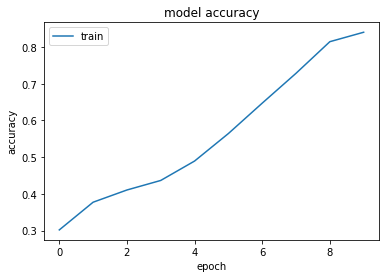

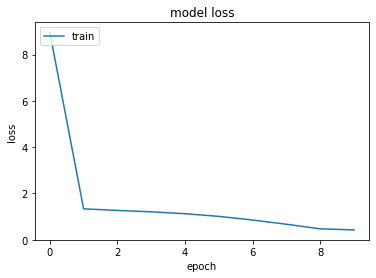

In [ ]:
headModel.evaluate(patient_test,label_test)
print(history2.history.keys())
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Le net v5

In [ ]:
model = keras.Sequential()

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(512,512,1)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))
model.add(Dropout(0.1))
model.add(layers.Dense(units=4, activation = 'softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#fitting the model
history3 = model.fit(patient_train,label_train,epochs=10)

Epoch 1/10
154/154 [==============================] - 9s 51ms/step - loss: 60.7584 - accuracy: 0.6214
Epoch 2/10
154/154 [==============================] - 8s 50ms/step - loss: 0.1285 - accuracy: 0.9561
Epoch 3/10
154/154 [==============================] - 8s 50ms/step - loss: 0.0497 - accuracy: 0.9839
Epoch 4/10
154/154 [==============================] - 8s 50ms/step - loss: 0.0315 - accuracy: 0.9890
Epoch 5/10
154/154 [==============================] - 8s 50ms/step - loss: 0.0252 - accuracy: 0.9906
Epoch 6/10
154/154 [==============================] - 8s 50ms/step - loss: 0.0350 - accuracy: 0.9874
Epoch 7/10
154/154 [==============================] - 8s 51ms/step - loss: 0.0554 - accuracy: 0.9827
Epoch 8/10
154/154 [==============================] - 8s 51ms/step - loss: 0.0606 - accuracy: 0.9823
Epoch 9/10
154/154 [==============================] - 8s 51ms/step - loss: 0.0570 - accuracy: 0.9833
Epoch 10/10
154/154 [==============================] - 8s 51ms/step - loss: 0.0228 - accur

76/76 [==============================] - 2s 19ms/step - loss: 0.0762 - accuracy: 0.9781
dict_keys(['loss', 'accuracy'])


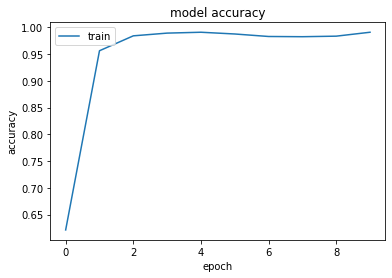

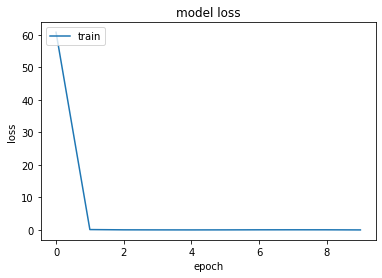

In [ ]:
model.evaluate(patient_test,label_test)
print(history3.history.keys())
# summarize history for accuracy
plt.plot(history3.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history3.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(patient_test,label_test)
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Data Flattening for compatability

In [ ]:
nsamples, nx, ny = patient_train.shape
patient_train2= patient_train.reshape((nsamples,nx*ny))
nsamples1, nx1, ny1 = patient_test.shape
patient_test2= patient_test.reshape((nsamples1,nx1*ny1))
print(np.shape(patient_train2))

(4918, 262144)


# SVM Models

Different Kernels

In [ ]:
model = svm.SVC(kernel = 'sigmoid')
model.fit(patient_train2, label_train)
pred = model.predict(patient_test2)
print("Accuracy:",metrics.accuracy_score(label_test, pred))

Accuracy: 0.3536937680561288


In [ ]:
model = svm.SVC(kernel = 'rbf')
model.fit(patient_train2, label_train)
pred = model.predict(patient_test2)
print("Accuracy:",metrics.accuracy_score(label_test, pred))

Accuracy: 0.8572018159306645


In [ ]:
model = svm.SVC(kernel = 'gaussian')
model.fit(patient_train2, label_train)
pred = model.predict(patient_test2)
print("Accuracy:",metrics.accuracy_score(label_test, pred))

In [ ]:
model = svm.SVC(kernel = 'bessel')
model.fit(patient_train2, label_train)
pred = model.predict(patient_test2)
print("Accuracy:",metrics.accuracy_score(label_test, pred))

ValueError: ignored

Margin Changes to C value

In [ ]:
model = svm.SVC(kernel = 'linear', C = 0.0000001)
model.fit(patient_train2, label_train)
pred = model.predict(patient_test2)
print("Accuracy:",metrics.accuracy_score(label_test, pred))

Accuracy: 0.9620305406520842


# RT Models

RT Model

In [ ]:
model=RandomForestClassifier(n_estimators=100)
model.fit(patient_train2, label_train)
pred1 = model.predict(patient_test2)
print("Accuracy:",metrics.accuracy_score(label_test, pred1))

Accuracy: 0.9570780024762691


RT optimization using search CV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42)
# Fit the random search model
rf_random.fit(patient_train2, label_train)
rf_random.best_params_
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy

base_accuracy = evaluate(model, patient_test2, label_test)
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, patient_test2, label_test)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 1.9min
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 1.9min
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 1.9min
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time= 8.6min
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; tota